In [16]:
import keras
import os
import tempfile
import keras.backend as K
import math
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import tensorflow as tf
import time
import pandas as pd
import seaborn as sns
import csv 
from sklearn.preprocessing import StandardScaler

from keras import optimizers, metrics
from keras import activations
from keras.layers import Dense, LayerNormalization, BatchNormalization, Dropout, GaussianNoise, Activation, Add

from tools.constants import column_labels_particle_assignment_btags as column_names

In [17]:
""" Data augmentation functions. Rotate all particles of an event (or a permutation of an event)
    by a random angle. """

def random_rotation(X,deltas_phi,num_vectors,met):

    for i in range(num_vectors):
        
        R = np.sqrt((X[:,4*i+0]**2 + X[:,4*i+1]**2))
        old_phis = np.arctan2(X[:,4*i+1],X[:,4*i+0])
        new_phis = old_phis + deltas_phi

        angles_sin = np.sin(new_phis)
        angles_cos = np.cos(new_phis)

        X[:,4*i+0] = angles_cos * R
        X[:,4*i+1] = angles_sin * R
        
    if met:
        return random_rotation_MET(X, deltas_phi)
    else:
        return X


def random_rotation_MET(X, deltas_phi):
    # Indices based on the data files structure.
    met_x_index = -6
    met_y_index = -5

    R = np.sqrt((X[:,met_x_index]**2 + X[:,met_y_index]**2))
    old_phis = np.arctan2(X[:,met_y_index],(X[:,met_x_index]))
    new_phis = old_phis + deltas_phi

    angles_sin = np.sin(new_phis)
    angles_cos = np.cos(new_phis)

    X[:,met_x_index] = angles_cos * R
    X[:,met_y_index] = angles_sin * R

    return X


def data_rotation(X, num_vectors_X = 11, met = True):  
    
    deltas_phi = np.random.rand(X.shape[0])*2*math.pi
    X = random_rotation(X,deltas_phi,num_vectors_X,met)
        
    return X

""" Data generator class. Used to serve data to the neural network.
    Modified from source https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly """

class DataGenerator(keras.utils.Sequence):

    def __init__(self, list_IDs, labels, batch_size=32, n_features=77, shuffle=True,\
                scaler = "scaler_params/particle_assignment_scaler_params.csv", data_path = "data/particle_assignment_training_data/data/",\
                with_ids = False, augmentation = False):
        self.n_features = n_features
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.data_path = data_path
        self.with_ids = with_ids
        self.augmentation = augmentation
        with open(scaler) as f:
            scaler_params = np.loadtxt(f, delimiter=",")
            self.scaler = scaler_params
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y, weights = self.__data_generation(list_IDs_temp)

        return X, y, weights

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples as X : (n_samples, *dim, n_channels)'
        
        # Initialization
        X = np.zeros((1,self.n_features),dtype=float)
        y = np.zeros((1,5),dtype=int)
        
        for i, ID in enumerate(list_IDs_temp):
            X = np.concatenate((X,np.load(self.data_path + str(int(ID)) + '.npy')),axis=0)
            y = np.concatenate((y,self.labels[str(int(ID))]),axis=0)
        X = X[1:,:column_names.index("true main px")]       # Get rid of the init row. Get rid of information you do not want to use (truth information).
        y = y[1:,:]                                         # Get rid of the init row.

        weights = np.reciprocal(X[:,-1])*200        # Sample weights are based on the number of permutations of an event - more permutations means smaller sample weight.
        X = X[:,:-1]        # Get rid of weights column.

        if self.with_ids:
            X = np.concatenate((X[:,0].reshape(len(X[:,0]),1),(X[:,1:]-self.scaler[0])/self.scaler[1]), axis = 1)   # Standardize everything except for EVENT IDS...
        else:
            X = X[:,1:]        # Get rid of EVENT ID column.

        if self.augmentation:
            X = data_rotation(X, num_vectors_X = 11, met = True)
        
        if self.with_ids:
            pass
        else:
            X = (X-self.scaler[0])/self.scaler[1]     # Standardize
        return X, y, weights
    
    def get_all(self):
        X = []
        y = []

        for i in range(self.__len__()):
            X_y = self.__getitem__(i)
            X += X_y[0].tolist()
            y += X_y[1].tolist()

        X = np.array(X)
        y = np.array(y)
        
        return X, y

In [18]:
""" Load data from files. """

with open("data/particle_assignment_training_data/labels_dict_ttH.csv") as f:
    lines_ttH = f.readlines()
with open("data/particle_assignment_training_data/labels_dict_ttZ.csv") as f:
    lines_ttZ = f.readlines()

with open("data/particle_assignment_training_data/train_ids_ttH.csv") as f:
    train_ids_ttH = np.loadtxt(f, delimiter=",")
with open("data/particle_assignment_training_data/train_ids_ttZ.csv") as f:
    train_ids_ttZ = np.loadtxt(f, delimiter=",")

with open("data/particle_assignment_training_data/test_ids_ttH.csv") as f:
    test_ids_ttH = np.loadtxt(f, delimiter=",")
with open("data/particle_assignment_training_data/test_ids_ttZ.csv") as f:
    test_ids_ttZ = np.loadtxt(f, delimiter=",")

with open("data/particle_assignment_training_data/val_ids_ttH.csv") as f:
    val_ids_ttH = np.loadtxt(f, delimiter=",")
with open("data/particle_assignment_training_data/val_ids_ttZ.csv") as f:
    val_ids_ttZ = np.loadtxt(f, delimiter=",")

train_ids = np.concatenate((train_ids_ttH,train_ids_ttZ), axis = 0)
test_ids = np.concatenate((test_ids_ttH,test_ids_ttZ), axis = 0)
val_ids = np.concatenate((val_ids_ttH,val_ids_ttZ), axis = 0)
lines = np.concatenate((lines_ttH,lines_ttZ), axis = 0)

labels_dict = {}

for line in lines:
    row = np.fromstring(line, dtype=float, sep=',')
    key = str(int(row[0]))
    value = (row[1:]).reshape((int(len(row[1:])/5),5))
    labels_dict[key] = value

training_generator = DataGenerator(train_ids, labels_dict, shuffle=True, with_ids=False, augmentation = True, data_path="data/particle_assignment_training_data/data/")
validation_generator = DataGenerator(val_ids, labels_dict, with_ids=False, augmentation = False, data_path="data/particle_assignment_training_data/data/")
testing_generator = DataGenerator(test_ids, labels_dict, shuffle=False, with_ids=False, augmentation = False, data_path="data/particle_assignment_training_data/data/")

In [19]:
""" Count all training samples. """
num_samples = 0
for i in range(len(training_generator)):
    num_samples += len(training_generator[i][0])
print(num_samples)

' for i in range(len(training_generator)):\n    num_samples += len(training_generator[i][0])\nprint(num_samples) '

In [20]:
""" Get scaler params from training data. """

""" X_train = np.empty((num_samples,71), dtype=float)
c = 0

for i in range(len(training_generator)):
    rows = len(training_generator[i][0][:])

    X_train[c:c+rows,:] = training_generator[i][0][:]
    c += rows

X_train = X_train[1:,:]
scaler = StandardScaler()
scaler.fit(X_train)

f = open("scaler_params/particle_assignment_scaler_params.csv", "w")
writer = csv.writer(f)
writer.writerow(scaler.mean_)
writer.writerow(scaler.scale_)
f.close() """

' X_train = np.empty((num_samples,71), dtype=float)\nc = 0\n\nfor i in range(len(training_generator)):\n    rows = len(training_generator[i][0][:])\n\n    X_train[c:c+rows,:] = training_generator[i][0][:]\n    c += rows\n\nX_train = X_train[1:,:]\nscaler = StandardScaler()\nscaler.fit(X_train)\n\nf = open("scaler_params/particle_assignment_scaler_params_btags.csv", "w")\nwriter = csv.writer(f)\nwriter.writerow(scaler.mean_)\nwriter.writerow(scaler.scale_)\nf.close() '

In [21]:
""" Get intial biases and weights for the unbalanced classification problem. """
y_train = np.empty((num_samples,5), dtype=int)
c = 0

for i in range(len(training_generator)):
    rows = len(training_generator[i][1][:])
    y_train[c:c+rows,:] = training_generator[i][1][:]
    c += rows

y_train = y_train[1:,:]

correct = np.count_nonzero(y_train, axis=0)
incorrect = np.ones(5)*y_train.shape[0] - correct
total = correct + incorrect
initial_bias = np.log([correct/incorrect])
initial_bias = initial_bias.flatten()

correct_weight = (total /2/correct) 
incorrect_weight = (total /2/incorrect) 

weights_means = (correct_weight + incorrect_weight)/2
correct_weight /= weights_means
incorrect_weight /= weights_means

class_weight = [{0: incorrect_weight[i], 1: correct_weight[i]} for i in range(len(correct_weight))]

class_weight_arr = np.concatenate((correct_weight,incorrect_weight))
class_weight_arr = np.reshape(class_weight_arr, (2,5))
print(class_weight_arr)

[[1.71793148 1.71420458 1.92717606 1.01680849 1.01062206]
 [0.28206852 0.28579542 0.07282394 0.98319151 0.98937794]]


In [22]:
""" Loss function for unbalanced classification. """
# source: https://stackoverflow.com/questions/46009619/keras-weighted-binary-crossentropy
def create_weighted_binary_crossentropy(ones_weights,zeros_weights):

    def weighted_binary_crossentropy(y_true, y_pred):

        b_ce = K.binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * ones_weights + (1. - y_true) * zeros_weights
        weighted_b_ce = weight_vector * b_ce

        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

In [38]:
""" Metrics. """
from keras.regularizers import l2

# source: https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras
def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# source: https://stackoverflow.com/questions/39895742/matthews-correlation-coefficient-with-keras
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      matthews_correlation,
      custom_f1,
]

""" NN architecture defined in this model. """

def lep_assignment_model(num_features=42, bias = None):
    if bias is not None:
        bias1 = tf.keras.initializers.Constant(bias[0])
        bias2 = tf.keras.initializers.Constant(bias[1])
        bias3 = tf.keras.initializers.Constant(bias[2])
        bias4 = tf.keras.initializers.Constant(bias[3])
        bias5 = tf.keras.initializers.Constant(bias[4])

    i = keras.Input(shape = (num_features,))

    dropout_1 = Dropout(0.2)(i)
    dense_1 = Dense(500, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_1)
    relu_1 = Activation(activations.relu)(dense_1)

    dropout_2 = Dropout(0.2)(relu_1)
    dense_2 = Dense(500, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_2)
    relu_2 = Activation(activations.relu)(dense_2)

    dropout_3 = Dropout(0.2)(relu_2)
    dense_3 = Dense(500, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_3)
    add_1 = Add()([dense_3,dense_1])
    relu_3 = Activation(activations.relu)(add_1)

    dropout_4 = Dropout(0.2)(relu_3)
    dense_4 = Dense(500, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_4)
    relu_4 = Activation(activations.relu)(dense_4)

    dropout_5 = Dropout(0.2)(relu_4)
    dense_5 = Dense(500, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_5)
    add_2 = Add()([dense_5,add_1])
    relu_5 = Activation(activations.relu)(add_2)

    dropout_6 = Dropout(0.2)(relu_5)
    dense_6 = Dense(500, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_6)
    relu_6 = Activation(activations.relu)(dense_6)

    dropout_7 = Dropout(0.2)(relu_6)
    o1 = Dense(1, activation='sigmoid', bias_initializer=bias1, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_7)
    o2 = Dense(1, activation='sigmoid', bias_initializer=bias2, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_7)
    o3 = Dense(1, activation='sigmoid', bias_initializer=bias3, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_7)
    o4 = Dense(1, activation='sigmoid', bias_initializer=bias4, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_7)
    o5 = Dense(1, activation='sigmoid', bias_initializer=bias5, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_7)
    o = keras.layers.Concatenate(axis=1)([o1,o2,o3,o4,o5])

    model = keras.Model(i, o)
    model.compile(loss=create_weighted_binary_crossentropy(class_weight_arr[0],class_weight_arr[1]), optimizer=optimizers.Adam(lr=0.0003), metrics=METRICS)
    return model

def scheduler(epoch, lr):
    return lr * 0.99

In [39]:
""" Init model. """
model = lep_assignment_model(67+4, initial_bias)
callback1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=5, restore_best_weights=True)
callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler)
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [46]:
""" Training. """
history = model.fit(training_generator, validation_data=validation_generator, epochs=5, verbose=1, callbacks=[callback1,callback2])

Epoch 1/5
85/85 [==============================] - 472s 6s/step - loss: 0.2581 - tp: 5400839.0000 - fp: 5063903.0000 - tn: 14379571.0000 - fn: 1477807.0000 - accuracy: 0.7515 - precision: 0.5161 - recall: 0.7852 - auc: 0.8556 - prc: 0.7246 - matthews_correlation: 0.4710 - custom_f1: 0.6228 - val_loss: 0.2351 - val_tp: 696976.0000 - val_fp: 606563.0000 - val_tn: 1835481.0000 - val_fn: 168540.0000 - val_accuracy: 0.7657 - val_precision: 0.5347 - val_recall: 0.8053 - val_auc: 0.8750 - val_prc: 0.7713 - val_matthews_correlation: 0.5016 - val_custom_f1: 0.6431
Epoch 2/5
85/85 [==============================] - 471s 6s/step - loss: 0.2573 - tp: 5403382.0000 - fp: 5051253.0000 - tn: 14392221.0000 - fn: 1475264.0000 - accuracy: 0.7521 - precision: 0.5168 - recall: 0.7855 - auc: 0.8563 - prc: 0.7263 - matthews_correlation: 0.4730 - custom_f1: 0.6241 - val_loss: 0.2370 - val_tp: 703653.0000 - val_fp: 586102.0000 - val_tn: 1855942.0000 - val_fn: 161863.0000 - val_accuracy: 0.7739 - val_precision:

In [49]:
""" Save trained model. """
import pickle

model.save_weights("models/particle_assignment_model")
model.save("models/particle_assignment_model")

with open('models/particle_assignment_model_history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

INFO:tensorflow:Assets written to: models/particle_assignment_model_btags/assets


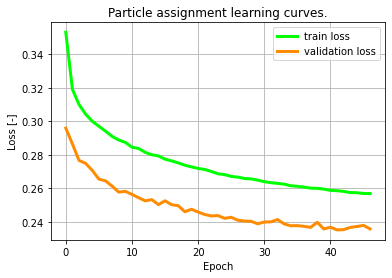

<Figure size 432x288 with 0 Axes>

In [42]:
""" History plot. """
plt.plot(history.history['loss'], linewidth=3, color='lime', linestyle='-')
plt.plot(history.history['val_loss'], linewidth=3, color='darkorange', linestyle='-')
plt.title('Particle assignment learning curves.')
plt.ylabel('Loss [-]')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.savefig('figures/PA_learning_curve.pdf')
plt.show()
plt.clf()

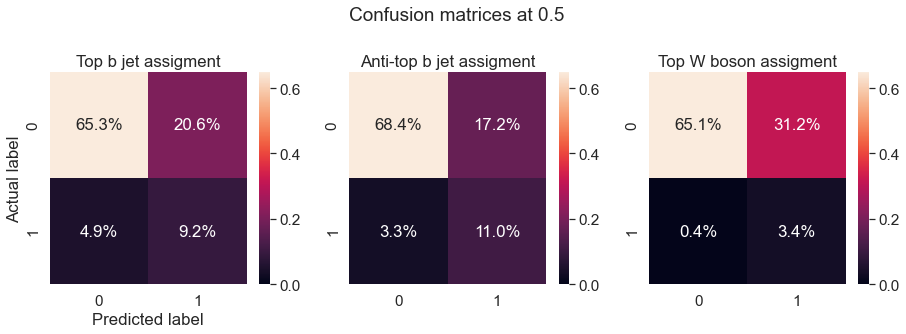

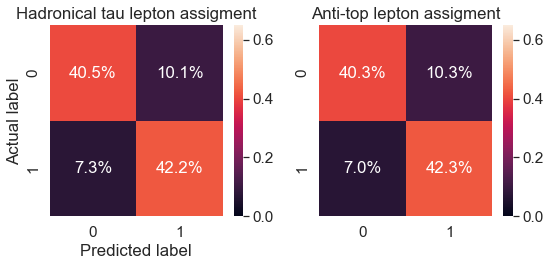

In [47]:
""" Confusion matrices. """
# inspired by source: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

from sklearn.metrics import confusion_matrix

test_predictions_baseline = model.predict(testing_generator)

n_batches = len(testing_generator)
y_test = np.concatenate([testing_generator[i][1] for i in range(n_batches)])


fig,axs = plt.subplots(1, 3, figsize=(13,4.8))

cm = confusion_matrix(y_test[:,0], test_predictions_baseline[:,0] > 0.5, normalize = 'all')
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt = '.1%', ax=axs[0], vmin = 0, vmax = 0.65)
plt.suptitle("Confusion matrices at 0.5", fontsize=19)
plt.rcParams.update({'axes.titlesize': 'large'})
plt.rcParams.update({'axes.labelsize': 'large'})
axs[0].title.set_text('{} assigment'.format("Top b jet"))
axs[0].set_ylabel('Actual label')
axs[0].set_xlabel('Predicted label')

cm = confusion_matrix(y_test[:,1], test_predictions_baseline[:,1] > 0.5, normalize = 'all')
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt = '.1%', ax=axs[1], vmin = 0, vmax = 0.65)

axs[1].title.set_text('{} assigment'.format("Anti-top b jet"))


cm = confusion_matrix(y_test[:,2], test_predictions_baseline[:,2] > 0.5, normalize = 'all')
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt = '.1%', ax=axs[2], vmin = 0, vmax = 0.65)

axs[2].title.set_text('{} assigment'.format("Top W boson"))

plt.tight_layout()
plt.savefig("figures/jest_assignment_btags_.pdf")
plt.show()


fig,axs = plt.subplots(1, 2, figsize=(8,4))

cm = confusion_matrix(y_test[:,3], test_predictions_baseline[:,3] > 0.5, normalize = 'all')
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt = '.1%', ax=axs[0], vmin = 0, vmax = 0.65)
axs[0].title.set_text('{} assigment'.format("Hadronical tau lepton"))
axs[0].set_ylabel('Actual label')
axs[0].set_xlabel('Predicted label')

cm = confusion_matrix(y_test[:,4], test_predictions_baseline[:,4] > 0.5, normalize = 'all')
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt = '.1%', ax=axs[1], vmin = 0, vmax = 0.65)
axs[1].title.set_text('{} assigment'.format("Anti-top lepton"))

plt.tight_layout()
plt.savefig("figures/cms.pdf")
plt.show()


In [48]:
for i in range(5):
    print(matthews_correlation(y_test[:,i].astype('float32'),test_predictions_baseline[:,i].astype('float32')))

tf.Tensor(0.31420153, shape=(), dtype=float32)
tf.Tensor(0.4416114, shape=(), dtype=float32)
tf.Tensor(0.2315869, shape=(), dtype=float32)
tf.Tensor(0.654064, shape=(), dtype=float32)
tf.Tensor(0.65451247, shape=(), dtype=float32)
